# **Content-aware image restoration (CARE) 2D**

<font size = 4>CARE is a neural network based architecture for image enhancement, first published in 2018 by Weigert et al. in Nature Methods (see above). The network allows image restoration and resolution improvement in 2D and 3D images, in a supervised manner, using noisy images as input and low-noise images as targets for training.

<font size = 4>Once the user is familiarised with functions of CARE, it can be instructive to explore in-depth features and functions of CARE in [this guide](http://csbdeep.bioimagecomputing.com/doc/) provided by the authors.

---

*Disclaimer*:

This notebook is part of the Zero-Cost Deep-Learning to Enhance Microscopy project (https://github.com/HenriquesLab/DeepLearning_Collab/wiki). Jointly developed by the Jacquemet (link to https://cellmig.org/) and Henriques (https://henriqueslab.github.io/) laboratories.

This notebook is largely based on the paper: **Content-aware image restoration: pushing the limits of fluorescence microscopy**, Nature Methods, Volume 15. pages 1090–1097(2018) by *Martin Weigert, Uwe Schmidt, Tobias Boothe, Andreas Müller, Alexandr Dibrov, Akanksha Jain, Benjamin Wilhelm, Deborah Schmidt, Coleman Broaddus, Siân Culley, Mauricio Rocha-Martins, Fabián Segovia-Miranda, Caren Norden, Ricardo Henriques, Marino Zerial, Michele Solimena, Jochen Rink, Pavel Tomancak, Loic Royer, Florian Jug & Eugene W. Myers* (https://www.nature.com/articles/s41592-018-0216-7)

And source code found in: https://github.com/csbdeep/csbdeep

More documentation on the CARE python package can be found here:
http://csbdeep.bioimagecomputing.com/doc/

Original The training and test data of the restoration experiments: https://publications.mpi-cbg.de/publications-sites/7207/


**Please also cite this original paper when using or developing this notebook.**

# **How to use this notebook?**
---

###**Table of contents, Code snippets** and **Files**

On the left side of the notebook you find three tabs which contain from top to bottom the table of contents, code snippets and files

*Table of contents* = contains structure of the notebook. Click the content to move quickly between sections.

*Code snippets* = contain examples how to code certain tasks. You can ignore this when using this notebook.

*Files* = contain all available files. After mounting your google drive (see section 1.) you will find your files and folders here. 

**Remember that all uploaded files are purged after changing the runtime.** All files saved in Google Drive will remain. You do not need to use the Mount Drive-button; your Google Drive is connected in section 1.2.

**Note:** The "sample data" in "Files" contains default files. Do not upload anything here!

---
###**Text** and **Code Cells**

**Text cells** provide information and can be modified by douple-clicking the cell. You are currently reading the text cell. You can create a new text by clicking `+ Text`.

**Code cells** contain code and the code can be modfied by selecting the cell. To execute the cell, move your cursor on the `[ ]`-mark on the left side of the cell (play button appear). Click to execute the cell. After execution is done the animation of play button stops. You can create a new coding cell by clicking `+ Code`.

---
###**Making changes to the notebook**

**Please make a copy** of the notebook and save it to your Google Drive if you make changes. To do this click file -> save a copy in drive.

To **edit a cell**, double click on the text. This will show you either the source code (in code cells) or the source text (in text cells).
It is advisable to use the `#`-mark in code cells. This allows you to keep the original code piece in the cell as a comment.

**For example:**

Original code: all lines are excuted

`my_files = 2`

`my_mask = "names of masks"`

Modified code: the 1st line is not executed, but the 2nd and 3rd line are.

`#my_files = 2`

`my_files = 200`

`my_mask = "names of masks"`

#**0. Before getting started**
---
<font size = 4>

1. Create the following folder tree in your Google Drive:

*   Data
    - train
      - GT (ground-truth)
        - img_1.tif, img_2.tif, ...
      - low
        - img_2.tif, img_2.tif, ...
    - prediction 
    - results

2. Place your low SNR images in the **low** folder and your ground truth (GT) images into **GT** folder. Corresponding **low and GT images** must have the **same name**.
3. Place all your test images in the **prediction** folder. Use only tif files!
4. **results** - folder will contain denoised images, trained model and training values as csv file. Your original images remain in test-folder and unmodified.

**Use only .tif files!**
---


# **1. Set the Runtime type and mount your Google Drive**



### **1.1. Change the Runtime type**



Go to **Runtime -> Change the Runtime type**

**Runtime type: Python 3** *(Python 3 is programming language in which this program is written)*

**Accelator: GPU** *(Graphics processing unit (GPU)*


### **1.2. Mount Google Drive**
<font size = 4> To use this notebook on your own data, you need to mount your Google Drive to this notebook.

<font size = 4> Play the below cell to mount your Google Drive and follow the link. In the new browser window, select your drive and select 'Allow', copy the code, paste into the cell and press enter.

In [45]:
#@markdown ###Mount Google Drive.

#mounts user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **2. Install CARE and Dependencies**


In [46]:
#@markdown ### Install CARE and dependencies

#Libraries contains information of certain topics. 
#For example the tifffile library contains information on how to handle tif-files.

#Here, we install libraries which are not already included in Colab.
!pip install tifffile # contains tools to operate tiff-files
!pip install csbdeep  # contains tools for restoration of fluorescence microcopy images (Content-aware Image Restoration, CARE). It uses Keras and Tensorflow.

#Here, we import and enable Tensorflow 1 instead of Tensorflow 2.
%tensorflow_version 1.x
import tensorflow
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print(tensorflow.__version__)
print("Tensorflow enabled.")

#Here, we import all libraries necessary for this notebook.
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from tifffile import imread, imsave
from csbdeep.utils import download_and_extract_zip_file, plot_some, axes_dict, plot_history, Path, download_and_extract_zip_file
from csbdeep.data import RawData, create_patches 
from csbdeep.io import load_training_data, save_tiff_imagej_compatible
from csbdeep.models import Config, CARE
from csbdeep import data
from pathlib import Path
import os, random
import shutil
import pandas as pd
import csv

!pip install memory_profiler
%load_ext memory_profiler

print("Depencies installed and imported.")

1.15.0
Tensorflow enabled.
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
Depencies installed and imported.


# **3. Select your parameters and paths**

---



<font size = 5> **Select paths for training, predictions and results**

<font size = 4>**`GT`, `low`:** To enter the paths of the folders containing the respective datasets, go to your files (bottom of left-hand column), navigate to the folder containing your files and copy the path by right-clicking on the folder and pasting into the respective box below.

<font size = 4>**`predictions`:** This folder should contains the images that you want to predict using the network that you will train.

<font size = 4>**`Results`:** This folder will contains the predicted images.

<font size = 4>**`name`:** Use only my_model -style, not my-model. If you want to use a previously trained model, enter the name of the pretrained model (which should be contained in the trained_model -folder after training)

<font size = 4>**`modelpath`**: Enter the path of the folder containing your new model or pretrained model.

<font size = 4>**If using a pretrained model, leave the rest of the below section blank. Parameters will be taken over from your model (see above)**

<font size = 5>**Select training Parameters**

<font size = 4>**`steps`:** Good network training may require at least 300 steps but will take a while.

<font size = 4>**`epochs`:** Input how many epochs (rounds) network will be trained. A larger number of epochs may improve performance but risks overfitting to the training data. Start with 10-30 and test the performance after training (see 4.8.)

<font size = 4>*`size`:** CARE divides the image into patches for training. Input the size of the patches (length of a side). The value should be smaller than the dimensions of the image and divisible to 8.

<font size = 4>**`number`:** Input the number of the patches per image. Increasing the number of patches allows for larger training datasets.  

<font size = 4>**Decreasing the patch size or increasing the number of patches may improve the training but may also increase the training time.**

In [60]:
#@markdown ###Path to training images:

# base folder of GT and low images
base = "/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/CARE 2D/Nucleus_datasets/train"
training_data = base+"/my_training_data.npz"

# Ground truth images
GT = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/Training datasets/CARE (2D)/Training - High SNR images" #@param {type:"string"}
GTfile = GT+"/*.tif"

# low SNR images
low = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/Training datasets/CARE (2D)/Training - Low SNR images" #@param {type:"string"}
lowfile = low+"/*.tif"

#@markdown ###Path to predicted images and results:
prediction = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/Training datasets/CARE (2D)/Test - Low SNR images" #@param {type:"string"}
results = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/test folder/Training datasets/CARE (2D)/Results" #@param {type:"string"}

# model name and path
#@markdown ###Name of the model and path to model folder:
modelname = "SIM_test5" #@param {type:"string"}
modelpath = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/test folder/Training datasets/CARE (2D)/Results" #@param {type:"string"}

# other parameters for training.
#@markdown ###Training Parameters
#@markdown Number of steps and epochs:
steps =  300#@param {type:"number"}
epochs = 100 #@param {type:"number"}
#@markdown Patch size (pixels) and number
size = 64 #@param {type:"number"} # pixels in
width = size
number =  2048#@param {type:"number"}

# The shape of the images.
y = imread(GTfile)
x = imread(lowfile)

print('Loaded GT images (number, width, length) =', y.shape)
print('Loaded low images (number, width, length) =', x.shape)
print("Parameters initiated.")


Loaded GT images (number, width, length) = (22, 1024, 1024)
Loaded low images (number, width, length) = (22, 1024, 1024)
Parameters initiated.


# **4. Train the network**


### **4.1. Inspecting training data**
<font size = 4>Here, we show an example to make sure the 'low' input matches a corresponding 'GT' target image.

In [61]:
#@markdown ###Play the cell to show the images.

# read the files in folder
y = imread(GTfile)
x = imread(lowfile)

# prints the shape of the y and x
print('Loaded GT images (number, width, length) =', y.shape)
print('Loaded low images (number, width, length) =', x.shape)

# create the plot
plt.figure(figsize=(16,10))
plot_some(np.stack([x[0],y[0]]),
          title_list=[['low image','GT image']], 
          pmin=2,pmax=99.8);

Output hidden; open in https://colab.research.google.com to view.

### **4.2. Prepare the training data and model for training**
<font size = 4>Here, we use the information from 3. to build the model and convert the training data into a suitable format for training.

   22 raw images x    1 transformations   =    22 images
   22 images     x 2048 patches per image = 45056 patches in total
Input data:
/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/CARE 2D/Nucleus_datasets/train: target='/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/Training datasets/CARE (2D)/Training - High SNR images', sources=['/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/Training datasets/CARE (2D)/Training - Low SNR images'], axes='CYX', pattern='*.tif*'
Transformations:
1 x Identity
Patch size:
64 x 64


100%|██████████| 22/22 [00:06<00:00,  3.58it/s]


Creating 2D training dataset
number of training images:	 40550
number of validation images:	 4506
image size (2D):		 (64, 64)
axes:				 SYXC
channels in / out:		 1 / 1
peak memory: 7000.85 MiB, increment: 0.02 MiB
Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=True, train_batch_size=64, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_epochs=100, train_learning_rate=0.0004, train_loss='laplace', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=300, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=5, unet_last_activation='linear', unet_n_depth=3, unet_n_first=32, unet_residual=True)


/usr/local/lib/python3.6/dist-packages/csbdeep/models/base_model.py:134: UserWarning: output path for model already exists, files may be overwritten: /content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/test folder/Training datasets/CARE (2D)/Results/SIM_test5
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


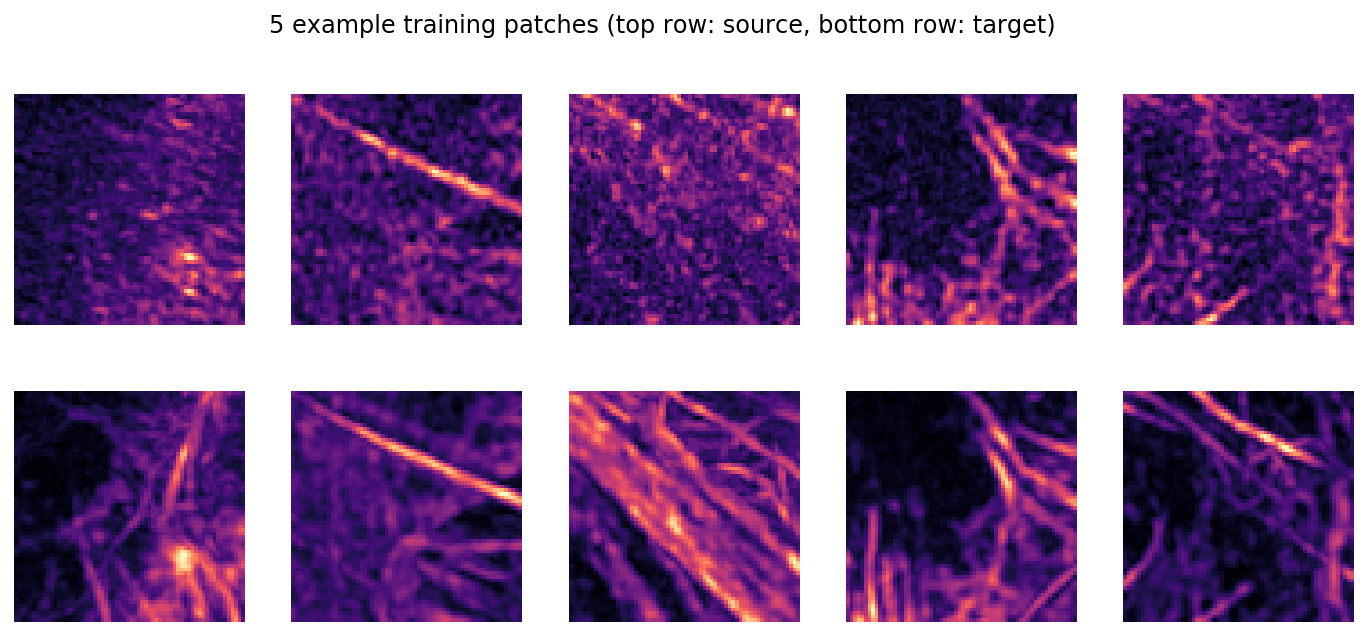

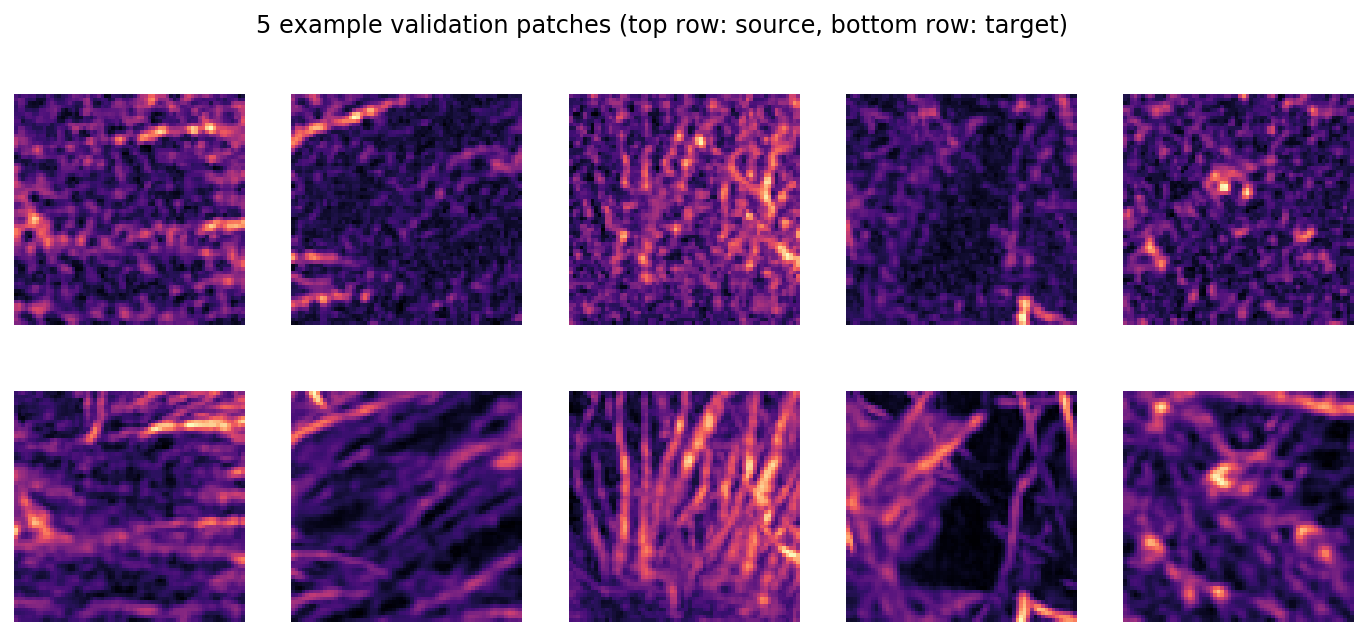

In [62]:
#@markdown ###Create the model and dataset objects
# The code in this cell is inspired by that from the authors' repository (https://github.com/CSBDeep/CSBDeep).

# RawData Object

# This object holds the image pairs (GT and low), ensuring that CARE compares corresponding images.
# This file is saved in .npz format and later called when loading the trainig data.

raw_data = data.RawData.from_folder(basepath=base, source_dirs=[low], target_dir=GT, axes='CYX', pattern='*.tif*')
X, Y, XY_axes = data.create_patches(raw_data, patch_filter=None, patch_size=(width,width), n_patches_per_image=number)
print ('Creating 2D training dataset')
rawdata1 = results+".npz"
np.savez(results,X=X, Y=Y, axes=XY_axes)

# Load Training Data

(X,Y), (X_val,Y_val), axes = load_training_data(rawdata1, validation_split=0.1, verbose=True)
c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

%memit 
# Plot example patches

#plot of training patches.
plt.figure(figsize=(12,5))
plot_some(X[:5],Y[:5])
plt.suptitle('5 example training patches (top row: source, bottom row: target)');

#plot of validation patches
plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

#Config Object:

#Here, we create the default Config object which sets the hyperparameters of the network training.
#In this case, we use the default settings from the paper. 
#More experienced users may want to experiment with these settings.

#Hyperparameters of the network training in the config file: 
# learning rate, 
# number of parameter updates per epoch,  
# is the model is probabilistic or not,
# number of neural network layers (unet_n_depth),
# kernel size (unet_kern_size - i.e. the size of the convolution filter)

# Do not change these default unless the notebooks crashes because of the defaults.

config = Config(axes, n_channel_in, n_channel_out, probabilistic=True, train_steps_per_epoch=steps, train_epochs=epochs, unet_kern_size=5, unet_n_depth=3, train_batch_size=width, train_learning_rate=0.0004)

print(config)
vars(config)

# Compile the CARE model for network training

model_training= CARE(config, modelname, basedir=results)

### **4.3. Train the network**
<font size = 4>When playing the cell below you should see updates after each epoch (round). Network training can take some time. You can estimate the training time by following equation: 

<font size = 4>t(training) = ( t(s)/epoch *x* epochs)/60. 

<font size = 4>**For example:**

<font size = 4>**t(training) = (16 s/epoch x 400 epochs)/60 = 106,7 min**

<font size = 4>* **CRITICAL NOTE:** Google Colab has time limit for processing (to prevent using GPU power for datamining). Training time must be less than 12 hours! If training takes longer than 12 hours, please decrease the training parameters or training data.

In [63]:
#@markdown ###Start Training

# Start Training
history = model_training.train(X,Y, validation_data=(X_val,Y_val))

print("Training, done.")

Epoch 1/100
300/300 [==============================] - 23s 76ms/step - loss: -0.6090 - mse: 0.0164 - mae: 0.0912 - val_loss: -0.7413 - val_mse: 0.0144 - val_mae: 0.0898
Epoch 2/100
300/300 [==============================] - 21s 68ms/step - loss: -0.8320 - mse: 0.0141 - mae: 0.0842 - val_loss: -0.8627 - val_mse: 0.0138 - val_mae: 0.0822
Epoch 3/100
300/300 [==============================] - 20s 67ms/step - loss: -0.8808 - mse: 0.0133 - mae: 0.0811 - val_loss: -0.8820 - val_mse: 0.0126 - val_mae: 0.0812
Epoch 4/100
300/300 [==============================] - 20s 67ms/step - loss: -0.8993 - mse: 0.0129 - mae: 0.0798 - val_loss: -0.8996 - val_mse: 0.0125 - val_mae: 0.0798
Epoch 5/100
300/300 [==============================] - 20s 67ms/step - loss: -0.9075 - mse: 0.0128 - mae: 0.0794 - val_loss: -0.8560 - val_mse: 0.0124 - val_mae: 0.0821
Epoch 6/100
300/300 [==============================] - 20s 67ms/step - loss: -0.9199 - mse: 0.0126 - mae: 0.0787 - val_loss: -0.9261 - val_mse: 0.0120 - va

### **4.4. Evaluate the training**

<font size = 4>It is good practice to evaluate the training progress by comparing the training loss with the validation loss. The latter is a metric which shows how well the network performs on a subset of unseen data which is set aside from the training dataset. For more information on this, see for example [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

<font size = 4>**Loss** <code>(loss)</code> describes an error value after each epoch for the difference between the model's prediction and its 'GT' target.

<font size = 4>**Validation error** <code>(val_loss)</code> describes the same error value between the model's prediction on a validation image (taken from 'low') and compared to it's target (from 'GT').

<font size = 4>During training both values should decrease before reaching a minimal value which does not decrease even after further training. Comparing the development of the validation error with the training error can give insights into the model's performance.

<font size = 4>If **validation error is clearly higher than training error**, it means that the training data might be too complex or diverse. In this case, the trained network fails to improve unseen images. To avoid this, increase the number of epochs and check if you can improve your dataset with more examples.

<font size = 4>If **validation error is clearly smaller than training error**, it means that training data is too simple which allows the network to learn the training data perfectly but to perform poorly on unseen data. This is called overfitting which should be always be avoided as it can lead to artefacts in the predctions of the network. First steps to avoid this can be to reduce the number of training epochs or to use a larger training dataset.

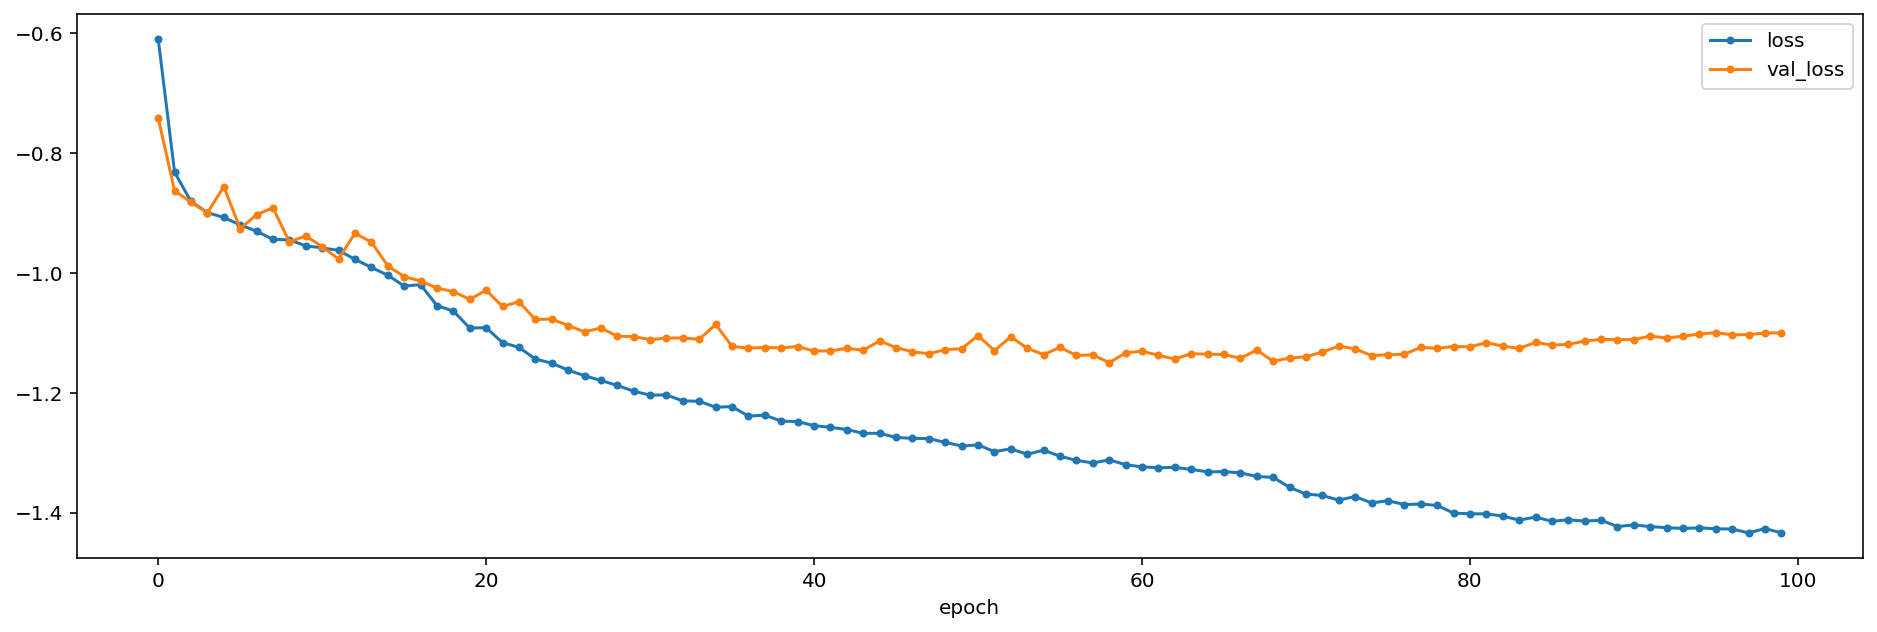

In [64]:
#@markdown ###Play the cell to show a figure of training errors

# data contains several values and they can be printed by this code. Just remove the #-mark.
# print(sorted(list(history.history.keys()))) 

#@title Play the cell to show figure of training results
# The code is inspired by the original code (https://github.com/CSBDeep/CSBDeep).
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# The figure is saved into content/ as test.csv (refresh the Files if needed). 
RESULTS = results+'/test.csv'
with open(RESULTS, 'w') as f:
    for key in hist_df.keys():
        f.write("%s,%s\n"%(key,hist_df[key]))

### **4.5. Export model to be used with *CSBDeep Fiji plugins* and *KNIME* workflows**

<font size = 4>This allows you to save the trained model in a format where it can be used in the CSBDeep Fiji Plugin. See https://github.com/CSBDeep/CSBDeep_website/wiki/Your-Model-in-Fiji for details.

<font size = 4>After saving the model to your drive, download the .zip file from your google drive. Do this from your Google Drive and not in the colab interface as this takes very long.

In [52]:
#@markdown ###Play this cell to save a Fiji compatible model to Google Drive.

# exports the trained model to Fiji.
# The code is from (https://github.com/CSBDeep/CSBDeep).
model_training.export_TF()



Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/tmpta168qmo/model/saved_model.pb

Model exported in TensorFlow's SavedModel format:
/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/Training datasets/CARE (2D)/Results/SIM_test4/TF_SavedModel.zip


# **5. Prediction**

---

<font size = 4>In this section the unseen data is predicted using the trained model (in section 4). First we upload your unseen images and prepare them for prediction. After that we activate your trained model from section 4 and finally we save results into your Google Drive.

### **5.1. Using the trained model for predictions**

<font size = 4>The trained model (from section 4.6) can now be used for images for which no ground-truth yet exists. Images are saved your results folder as restored image stacks ( ImageJ-compatible TIFF images).

In [65]:
#Activate the pretrained model. 
model_training = CARE(config=None, name=modelname, basedir=modelpath)

#@markdown ### Play the cell to predict your unseen images

# creates a loop, creating filenames and saving them
for filename in os.listdir(prediction):
  img = imread(os.path.join(prediction,filename))
  restored = model_training.predict(img, axes='YX')
  os.chdir(results)
  imsave(filename,restored)

print("Images saved into folder:", results)

Loading network weights from 'weights_best.h5'.
Images saved into folder: /content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/test folder/Training datasets/CARE (2D)/Results


Text(0.5, 1.0, 'Prediction')

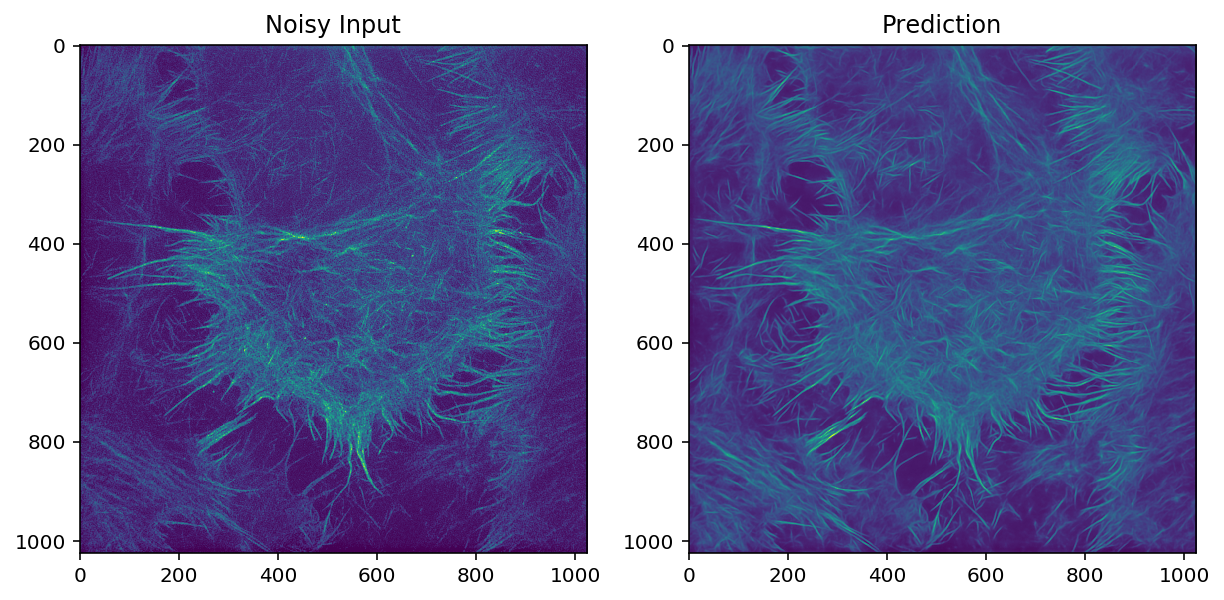

In [66]:
#@markdown ###Play this cell to display an example of a pair unseen input and the model's prediction
random_choice=random.choice(os.listdir(prediction))
x = imread(prediction+"/"+random_choice)

os.chdir(results)
y = imread(results+"/"+random_choice)

f=plt.figure(figsize=(10,20))
plt.subplot(1,2,1)

plt.imshow(x, interpolation='nearest')
plt.title('Noisy Input')
plt.subplot(1,2,2)

plt.imshow(y, interpolation='nearest')
plt.title('Prediction')

# **6. Store your results**

---
<font size = 4>**Store your data** and ALL its results elsewhere and after that clean the original folder tree (datasets, results, trained model etc.) if you plan to train or use new networks. Please note that notebook will **OVERWRITE** all files which have the same name.